# Preamble

In [56]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.graphical_analysis as pet_grph
import nibabel
import json

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

$$\require{mchem}$$

# Loading Data & Resampling Plasma TAC (pTAC)

## Loading In A 4D-PET Image

In [8]:
DATA_DIR = '../../../../PracticeData/'

In [9]:
pet_img = nibabel.load(f"{DATA_DIR}/4DPET/1179307_v2_STC_PVC.nii.gz")

In [10]:
img_vals = pet_img.get_fdata()
img_vals.shape

(176, 240, 256, 52)

## Loading Arterial Input Function

In [18]:
arterial_input_function = np.loadtxt(f"{DATA_DIR}BloodData_CMS/1179307_v2.csv", skiprows=1, delimiter=',')

aif_tac   = np.array([arterial_input_function[:,1], arterial_input_function[:,-1]], 
                                   order="C", dtype='float')

aif_tac

array([[3.73330e-06, 2.16670e-01, 3.83340e-01, 6.66670e-01, 8.83340e-01,
        1.05000e+00, 1.25000e+00, 1.41670e+00, 1.60000e+00, 1.78330e+00,
        2.03334e+00, 2.18334e+00, 2.31667e+00, 2.46667e+00, 2.61667e+00,
        2.85000e+00, 3.06667e+00, 3.33334e+00, 3.58334e+00, 3.81667e+00,
        4.08334e+00, 4.33334e+00, 4.58334e+00, 4.83334e+00, 5.33334e+00,
        5.75000e+00, 6.70000e+00, 7.71667e+00, 8.71667e+00, 9.70000e+00,
        1.07000e+01, 1.27000e+01, 1.57000e+01, 2.06500e+01, 2.56500e+01,
        3.06500e+01, 3.56500e+01, 4.56500e+01, 6.06500e+01],
       [6.22500e-05, 6.75620e-05, 1.21810e+00, 2.21840e+00, 8.36830e-01,
        6.13820e-01, 5.24330e-01, 4.76340e-01, 4.65450e-01, 4.67900e-01,
        4.70964e-01, 4.30692e-01, 4.55850e-01, 4.38788e-01, 4.30899e-01,
        4.23412e-01, 4.02504e-01, 3.87883e-01, 3.87879e-01, 3.80343e-01,
        3.71751e-01, 3.61616e-01, 3.59765e-01, 3.55952e-01, 3.46931e-01,
        3.35135e-01, 3.19147e-01, 3.09760e-01, 2.94450e-01, 2.8

### Plotting pTAC

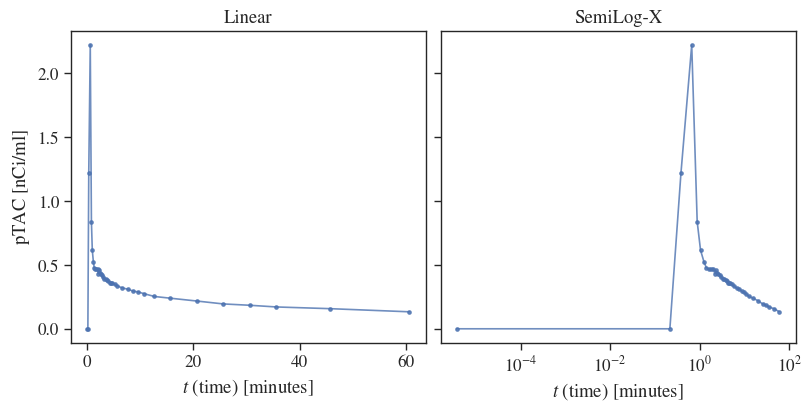

In [51]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*aif_tac, '.-', alpha=0.8)
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')

plt.show()

## Resampling pTAC At Scanner Frame Times

### Loading In Scanner Frame Times

In [40]:
scanner_times = []
with open("../../../../PracticeData/ScannerFrameTimes_CMS/1179307_v2_info.json") as dFile:
    scanner_times = np.array(json.load(dFile)['FrameReferenceTime'], order='C', dtype=float)/60.
scanner_times

array([2.49981667e-02, 1.08331500e-01, 1.91665000e-01, 2.74998333e-01,
       3.58331667e-01, 4.41665000e-01, 5.24998333e-01, 6.08331667e-01,
       6.91665000e-01, 7.74998333e-01, 8.58331667e-01, 9.41665000e-01,
       1.02499833e+00, 1.10833167e+00, 1.19166500e+00, 1.27499833e+00,
       1.35833167e+00, 1.44166500e+00, 1.52499833e+00, 1.60833167e+00,
       1.69166667e+00, 1.77500000e+00, 1.85833333e+00, 1.94166667e+00,
       2.14996667e+00, 2.48330000e+00, 2.81663333e+00, 3.14996667e+00,
       3.48330000e+00, 3.81663333e+00, 4.14996667e+00, 4.48330000e+00,
       4.81663333e+00, 5.48306667e+00, 6.48306667e+00, 7.48306667e+00,
       8.48306667e+00, 9.48306667e+00, 1.04830667e+01, 1.14830667e+01,
       1.24830667e+01, 1.34830667e+01, 1.44830667e+01, 1.74768333e+01,
       2.24768333e+01, 2.74768333e+01, 3.24768333e+01, 3.74768333e+01,
       4.24768333e+01, 4.74768333e+01, 5.24768333e+01, 5.74768333e+01])

### Interpolating pTAC On Scanner Frame Times

In [41]:
from pet_cli.blood_input import BloodInputFunction

In [42]:
scanner_aif = BloodInputFunction(time=aif_tac[0], activity=aif_tac[1], thresh_in_mins=30.0)
aif_on_scanner_tac = np.array([scanner_times, scanner_aif.calc_blood_input_function(x=scanner_times)],
                           dtype=float, order='C')

### Plotting Resampled pTAC

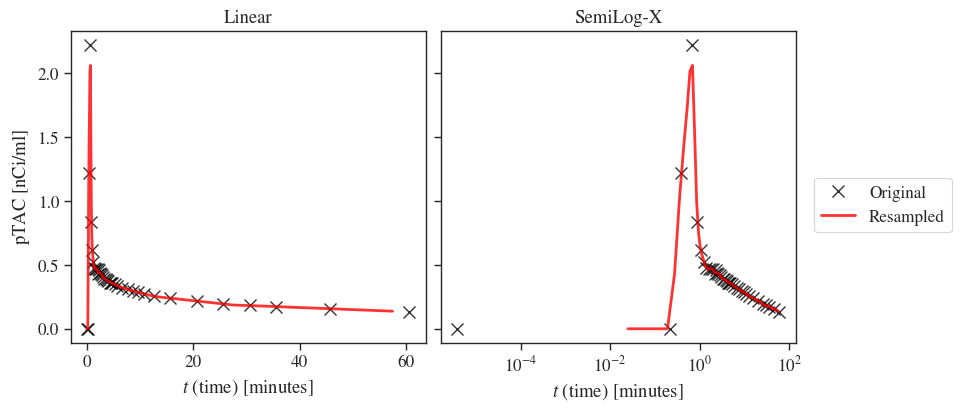

In [53]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*aif_tac, 'x', alpha=0.8, label='Original', color='black', ms=8)
    anAx.plot(*aif_on_scanner_tac, '-', alpha=0.8, label='Resampled', color='red', lw=2)
    anAx.set(xlabel=r'$t$ (time) [minutes]')
    
    

myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.show()

### Saving Resampled pTAC To File

In [55]:
np.savetxt(fname="../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt", 
           X=aif_on_scanner_tac.T,
          header='Time (s), Activity (nCu)', fmt='%.6e')

# Generating Parametric Images: Explicitly Looping Over All Voxels